In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np

%run ../db.py
%run ../database.py
%run ../utils.py


In [2]:
cgreen = '#27ae60'
cblue = '#2980b9'
cred = '#c0392b'
corange = '#d35400'
cgrey = '#7f8c8d'
cdark = '#2c3e50'
cwithe = '#ecf0f1'

figsize = (10, 6)

In [3]:
spec = {
    'data_base': 'Mês',
    'anterior': dt.year - 1,
    'meta': 'Meta',
    'arrecadado': dt.year,
    'dif_anterior': f'{dt.year} - {dt.year - 1}',
    'dif_perc_ant': f'{dt.year} / {dt.year - 1}',
    'dif_meta': f'{dt.year} - Meta',
    'dif_perc_meta': f'{dt.year} / Meta'
}
fmt = {
    'data_base': date_to_month_name,
    'anterior': money_formatter,
    'meta': money_formatter,
    'arrecadado': money_formatter,
    'dif_anterior': money_formatter,
    'dif_perc_ant': perc0_formatter,
    'dif_meta': money_formatter,
    'dif_perc_meta': perc0_formatter,
}

In [4]:
def plot_mensal(df, titulo):
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(titulo, x=0, fontsize=16)
    plt.title('valores mensais', x=0)
    x = df['data_base'].dt.strftime('%b')
    bar_width = 0.25
    x_pos = np.arange(len(x))
    plt.bar(x_pos - bar_width, df['anterior'], color=cblue, label=str(dt.year - 1), width=bar_width, align='center')
    plt.bar(x_pos, df['meta'], color=cgrey, label='Meta', width=bar_width, align='center')
    plt.bar(x_pos + bar_width, df['arrecadado'], color=cgreen, label='Arrecadado', width=bar_width, align='center')
    plt.ylim(bottom=0)
    ax.yaxis.set_major_formatter(int_formatter)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(x)
    plt.legend(loc='upper left', ncol=3)
    plt.show()
    

def plot_acumulado(df, titulo):
    fig, ax = plt.subplots(figsize=figsize)
    fig.suptitle(titulo, x=0, fontsize=16)
    plt.title('valores acumulados', x=0)
    x = df['data_base'].dt.strftime('%b')
    plt.plot(x, df['anterior'], color=cblue, label=str(dt.year - 1), marker='o')
    plt.plot(x, df['meta'], color=cgrey, label='Meta', linestyle='--')
    plt.plot(x, df['arrecadado'], color=cgreen, label='Arrecadado', marker='^')
    plt.ylim(bottom=0)
    ax.yaxis.set_major_formatter(int_formatter)
    plt.legend(loc='upper left', ncol=3)
    plt.show()

    
def prepara_df_acumulado(df):
    df['arrecadado'] = df['arrecadado'].cumsum()
    df['meta'] = df['meta'].cumsum()
    df['anterior'] = df['anterior'].cumsum()
    df['dif_meta'] = df['arrecadado'] - df['meta']
    df['dif_perc_meta'] = (df['arrecadado'] / df['meta']) - 1
    df['dif_anterior'] = df['arrecadado'] - df['anterior']
    df['dif_perc_ant'] = (df['arrecadado'] / df['anterior']) - 1
    return df

def prepara_df_mensal(df):
    df['dif_meta'] = df['arrecadado'] - df['meta']
    df['dif_perc_meta'] = (df['arrecadado'] / df['meta']) - 1
    df['dif_anterior'] = df['arrecadado'] - df['anterior']
    df['dif_perc_ant'] = (df['arrecadado'] / df['anterior']) - 1
    return df


# Receitas

Nesta parte são demonstradas as receitas da **Prefeitura**, excluídas, portanto, as receias do *RPPS*. Também são excluídas as receitas *intra-orçamentárias*.

As receitas são apresentadas em seus valores líquidos das deduções da receita.

## Receita Total

In [5]:
nome_receita = 'Receita Total'
sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado,
    SUM(meta_mensal) AS meta
FROM pad."RECEITA"

WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_atual = sqldf(sql)
#receita_atual

sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado
FROM pad."RECEITA"

WHERE
    controle = {controle_mes_ano_anterior}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_anterior = sqldf(sql)
#receita_anterior

receita = receita_atual
receita['anterior'] = receita_anterior['arrecadado']
receita['data_base'] = pd.to_datetime(receita['data_base'], format='%Y-%m-%d')
#receita.dtypes

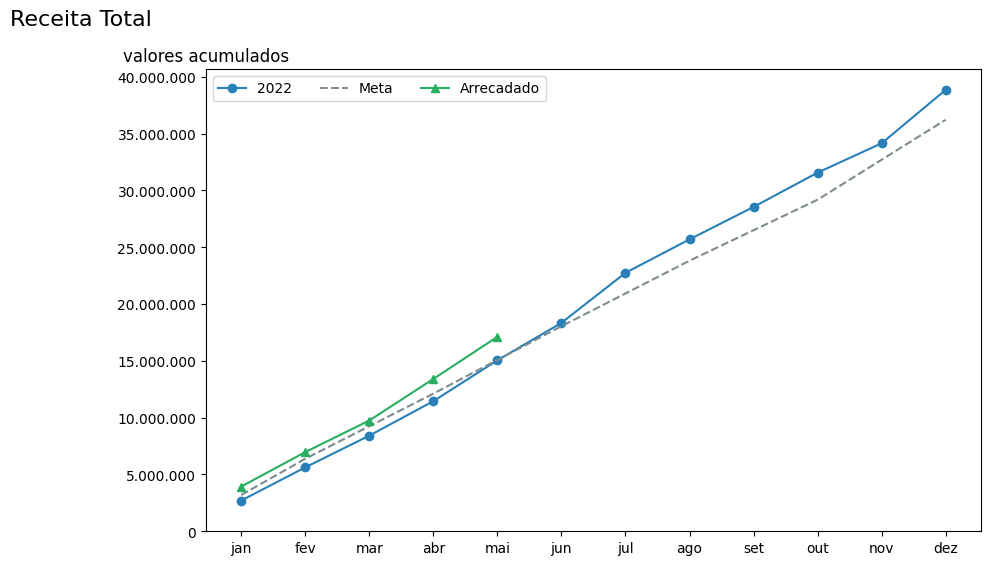

In [6]:
acumulado = prepara_df_acumulado(receita.copy())
plot_acumulado(acumulado, nome_receita)

In [7]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"2.700.638,48","3.191.014,14","3.935.209,83","1.234.571,35",46%,"744.195,69",23%
fev,"5.625.551,62","6.382.028,26","6.967.114,75","1.341.563,13",24%,"585.086,49",9%
mar,"8.417.137,53","9.248.275,69","9.748.696,62","1.331.559,09",16%,"500.420,93",5%
abr,"11.452.833,53","12.114.523,10","13.408.603,81","1.955.770,28",17%,"1.294.080,71",11%
mai,"15.050.552,60","15.082.914,43","17.117.043,21","2.066.490,61",14%,"2.034.128,78",13%
jun,"18.344.047,78","18.051.305,76",,,,,
jul,"22.753.006,46","20.934.713,09",,,,,
ago,"25.697.624,11","23.818.120,42",,,,,
set,"28.552.655,44","26.502.951,25",,,,,
out,"31.573.835,64","29.187.782,08",,,,,


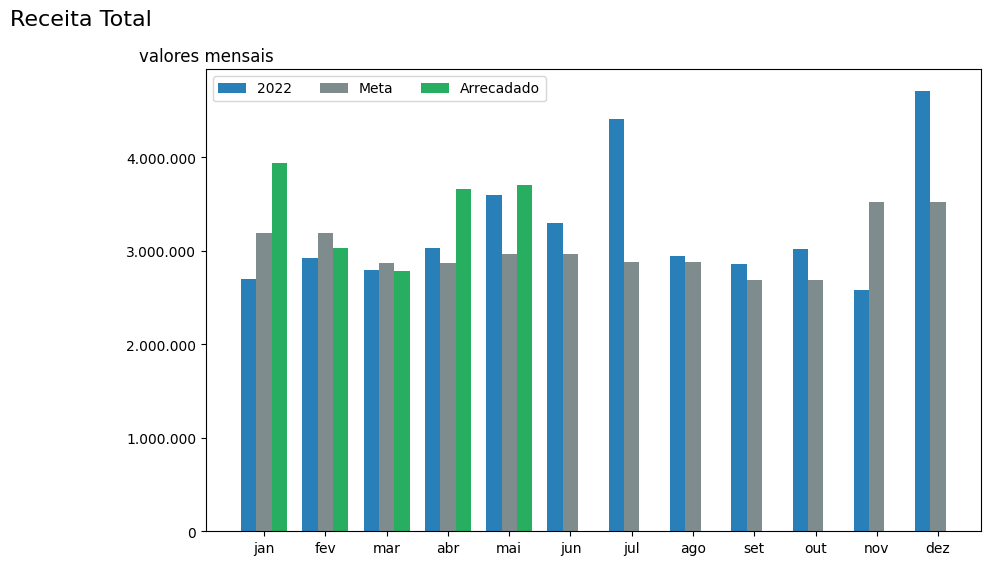

In [8]:
mensal = prepara_df_mensal(receita.copy())
plot_mensal(mensal, nome_receita)

In [9]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores mensais - {dt.year}').hide(axis='index')

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"2.700.638,48","3.191.014,14","3.935.209,83","1.234.571,35",46%,"744.195,69",23%
fev,"2.924.913,14","3.191.014,12","3.031.904,92","106.991,78",4%,"(159.109,20)",(5%)
mar,"2.791.585,91","2.866.247,43","2.781.581,87","(10.004,04)",-,"(84.665,56)",(3%)
abr,"3.035.696,00","2.866.247,41","3.659.907,19","624.211,19",21%,"793.659,78",28%
mai,"3.597.719,07","2.968.391,33","3.708.439,40","110.720,33",3%,"740.048,07",25%
jun,"3.293.495,18","2.968.391,33",,,,,
jul,"4.408.958,68","2.883.407,33",,,,,
ago,"2.944.617,65","2.883.407,33",,,,,
set,"2.855.031,33","2.684.830,83",,,,,
out,"3.021.180,20","2.684.830,83",,,,,


## Receita Corrente

In [10]:
nome_receita = 'Receita Corrente'
sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado,
    SUM(meta_mensal) AS meta
FROM pad."RECEITA"

WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '1%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_atual = sqldf(sql)
#receita_atual

sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado
FROM pad."RECEITA"

WHERE
    controle = {controle_mes_ano_anterior}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '1%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_anterior = sqldf(sql)
#receita_anterior

receita = receita_atual
receita['anterior'] = receita_anterior['arrecadado']
receita['data_base'] = pd.to_datetime(receita['data_base'], format='%Y-%m-%d')
#receita.dtypes

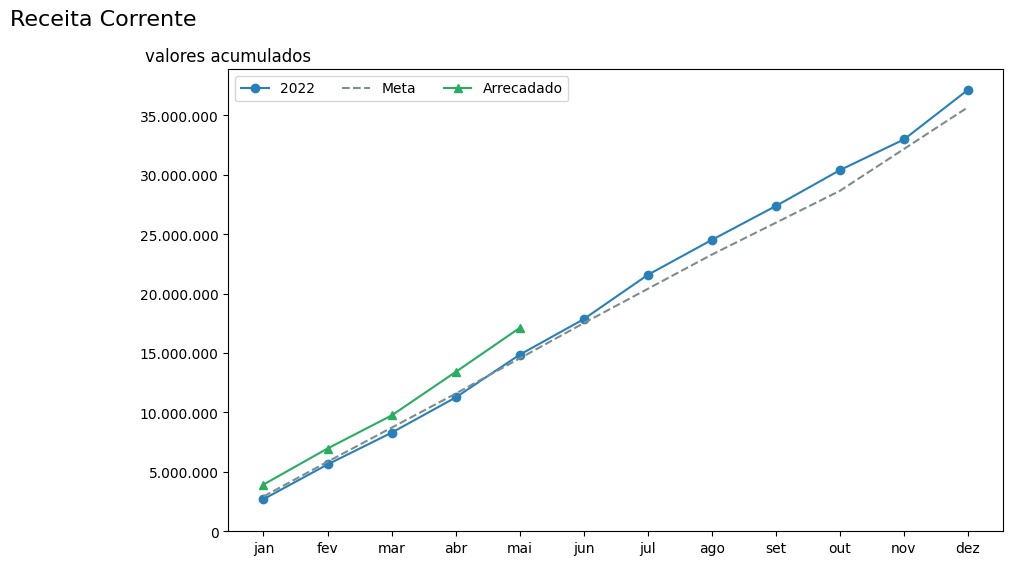

In [11]:
acumulado = prepara_df_acumulado(receita.copy())
plot_acumulado(acumulado, nome_receita)

In [12]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"2.700.638,48","2.927.110,46","3.935.209,83","1.234.571,35",46%,"1.008.099,37",34%
fev,"5.625.551,62","5.854.220,92","6.967.114,75","1.341.563,13",24%,"1.112.893,83",19%
mar,"8.297.137,53","8.720.468,35","9.748.696,62","1.451.559,09",17%,"1.028.228,27",12%
abr,"11.263.178,53","11.586.715,76","13.408.603,81","2.145.425,28",19%,"1.821.888,05",16%
mai,"14.860.897,60","14.555.107,09","17.117.043,21","2.256.145,61",15%,"2.561.936,12",18%
jun,"17.855.826,78","17.523.498,42",,,,,
jul,"21.581.919,96","20.406.905,75",,,,,
ago,"24.526.537,61","23.290.313,08",,,,,
set,"27.381.568,94","25.975.143,91",,,,,
out,"30.402.749,14","28.659.974,74",,,,,


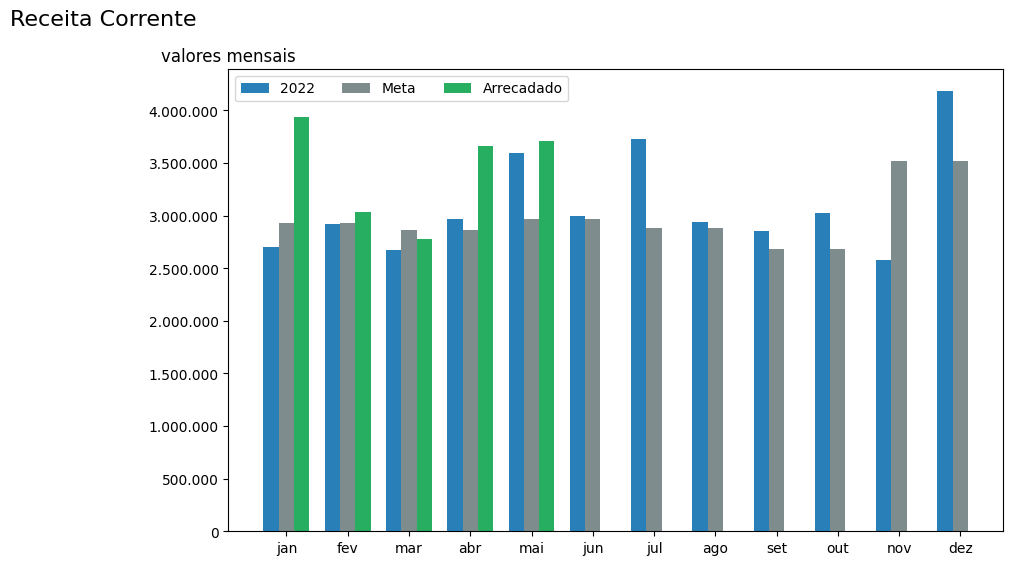

In [13]:
mensal = prepara_df_mensal(receita.copy())
plot_mensal(mensal, nome_receita)

In [14]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores mensais - {dt.year}').hide(axis='index')

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"2.700.638,48","2.927.110,46","3.935.209,83","1.234.571,35",46%,"1.008.099,37",34%
fev,"2.924.913,14","2.927.110,46","3.031.904,92","106.991,78",4%,"104.794,46",4%
mar,"2.671.585,91","2.866.247,43","2.781.581,87","109.995,96",4%,"(84.665,56)",(3%)
abr,"2.966.041,00","2.866.247,41","3.659.907,19","693.866,19",23%,"793.659,78",28%
mai,"3.597.719,07","2.968.391,33","3.708.439,40","110.720,33",3%,"740.048,07",25%
jun,"2.994.929,18","2.968.391,33",,,,,
jul,"3.726.093,18","2.883.407,33",,,,,
ago,"2.944.617,65","2.883.407,33",,,,,
set,"2.855.031,33","2.684.830,83",,,,,
out,"3.021.180,20","2.684.830,83",,,,,


## Arrecadação Própria

As receitas de **arrecadação prórpria** são as receitas correntes exceto as transferências e as receitas de rendimenos financeiros e expressam aquelas receitas cujo esforço de arrecadação é exclusivo do Município.

In [15]:
nome_receita = 'Arrecadação Própria'
sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado,
    SUM(meta_mensal) AS meta
FROM pad."RECEITA"

WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base NOT LIKE '17%%'
    AND receita_base NOT LIKE '132%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_atual = sqldf(sql)
#receita_atual

sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado
FROM pad."RECEITA"

WHERE
    controle = {controle_mes_ano_anterior}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '1%%'
    AND receita_base NOT LIKE '17%%'
    AND receita_base NOT LIKE '132%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_anterior = sqldf(sql)
#receita_anterior

receita = receita_atual
receita['anterior'] = receita_anterior['arrecadado']
receita['data_base'] = pd.to_datetime(receita['data_base'], format='%Y-%m-%d')
#receita.dtypes

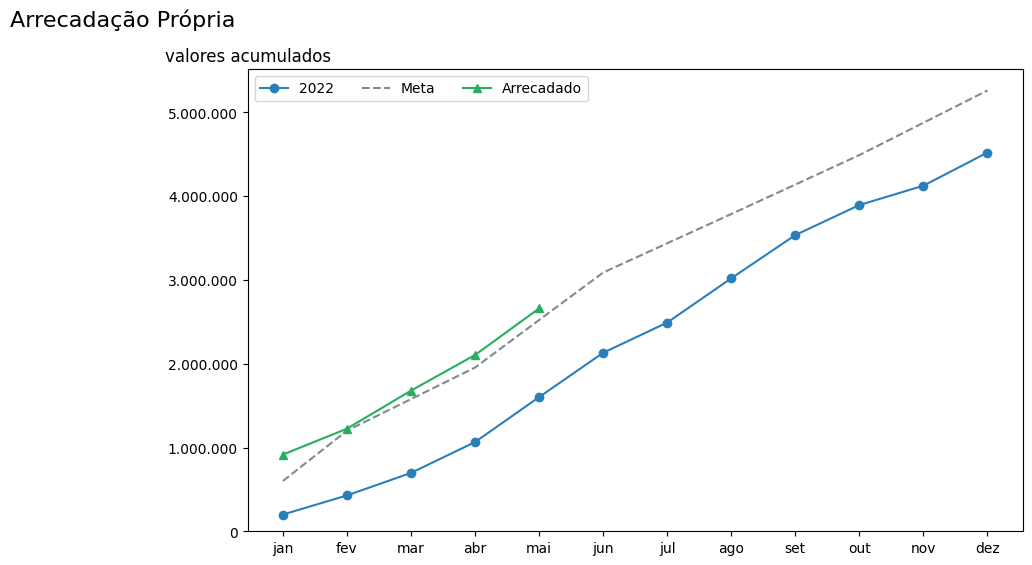

In [16]:
acumulado = prepara_df_acumulado(receita.copy())
plot_acumulado(acumulado, nome_receita)

In [17]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"199.771,02","600.486,93","915.805,17","716.034,15",358%,"315.318,24",53%
fev,"428.137,02","1.200.973,84","1.224.702,03","796.565,01",186%,"23.728,19",2%
mar,"696.804,63","1.578.057,09","1.679.232,82","982.428,19",141%,"101.175,73",6%
abr,"1.065.434,77","1.955.140,34","2.104.976,64","1.039.541,87",98%,"149.836,30",8%
mai,"1.602.031,48","2.522.223,59","2.660.641,76","1.058.610,28",66%,"138.418,17",5%
jun,"2.131.201,55","3.089.306,84",,,,,
jul,"2.491.926,62","3.438.390,09",,,,,
ago,"3.020.332,10","3.787.473,34",,,,,
set,"3.536.505,34","4.139.556,59",,,,,
out,"3.895.026,85","4.491.639,84",,,,,


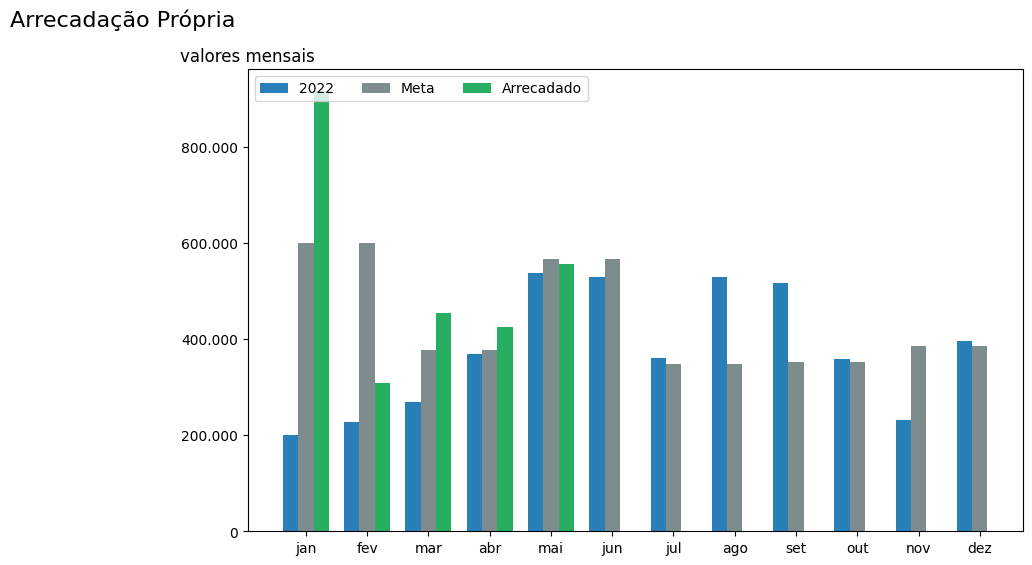

In [18]:
mensal = prepara_df_mensal(receita.copy())
plot_mensal(mensal, nome_receita)

In [19]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores mensais - {dt.year}').hide(axis='index')

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"199.771,02","600.486,93","915.805,17","716.034,15",358%,"315.318,24",53%
fev,"228.366,00","600.486,91","308.896,86","80.530,86",35%,"(291.590,05)",(49%)
mar,"268.667,61","377.083,25","454.530,79","185.863,18",69%,"77.447,54",21%
abr,"368.630,14","377.083,25","425.743,82","57.113,68",15%,"48.660,57",13%
mai,"536.596,71","567.083,25","555.665,12","19.068,41",4%,"(11.418,13)",(2%)
jun,"529.170,07","567.083,25",,,,,
jul,"360.725,07","349.083,25",,,,,
ago,"528.405,48","349.083,25",,,,,
set,"516.173,24","352.083,25",,,,,
out,"358.521,51","352.083,25",,,,,


### Receita da Dívida Ativa

In [20]:
nome_receita = 'Receita da Dívida Ativa'
sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado,
    SUM(meta_mensal) AS meta
FROM pad."RECEITA"

WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND tipo_receita IN (3, 4, 5, 6, 7, 8)
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_atual = sqldf(sql)
#receita_atual

sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado
FROM pad."RECEITA"

WHERE
    controle = {controle_mes_ano_anterior}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND tipo_receita IN (3, 4, 5, 6, 7, 8)
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_anterior = sqldf(sql)
#receita_anterior

receita = receita_atual
receita['anterior'] = receita_anterior['arrecadado']
receita['data_base'] = pd.to_datetime(receita['data_base'], format='%Y-%m-%d')
#receita.dtypes

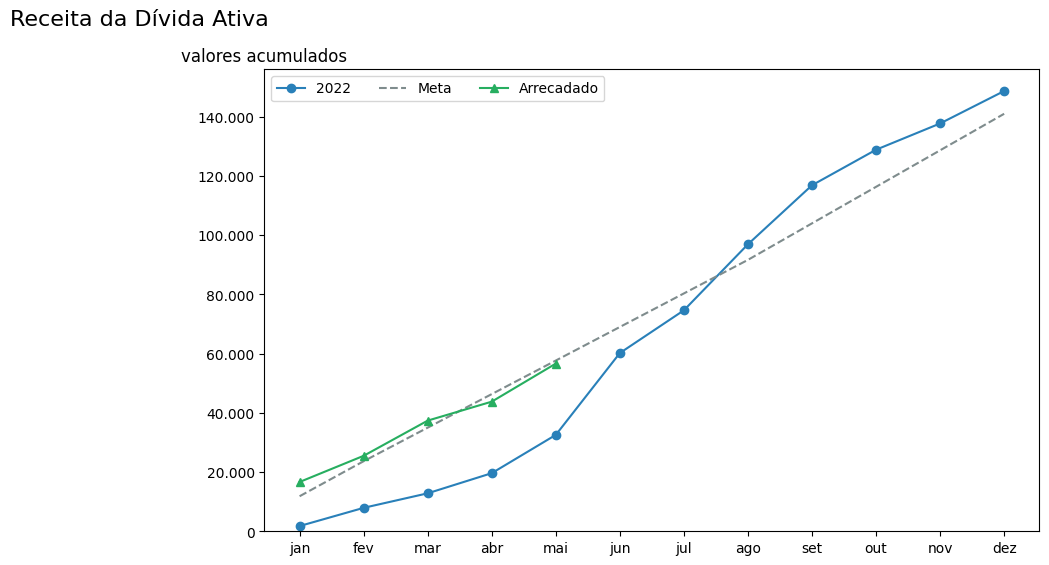

In [21]:
acumulado = prepara_df_acumulado(receita.copy())
plot_acumulado(acumulado, nome_receita)

In [22]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"1.769,14","11.833,31","16.647,96","14.878,82",841%,"4.814,65",41%
fev,"7.916,70","23.666,62","25.491,30","17.574,60",222%,"1.824,68",8%
mar,"12.825,54","34.999,93","37.377,76","24.552,22",191%,"2.377,83",7%
abr,"19.625,09","46.333,24","43.779,55","24.154,46",123%,"(2.553,69)",(6%)
mai,"32.553,45","57.666,55","56.636,47","24.083,02",74%,"(1.030,08)",(2%)
jun,"60.195,89","68.999,86",,,,,
jul,"74.636,07","80.333,17",,,,,
ago,"96.937,86","91.666,48",,,,,
set,"116.866,43","103.999,79",,,,,
out,"128.865,71","116.333,10",,,,,


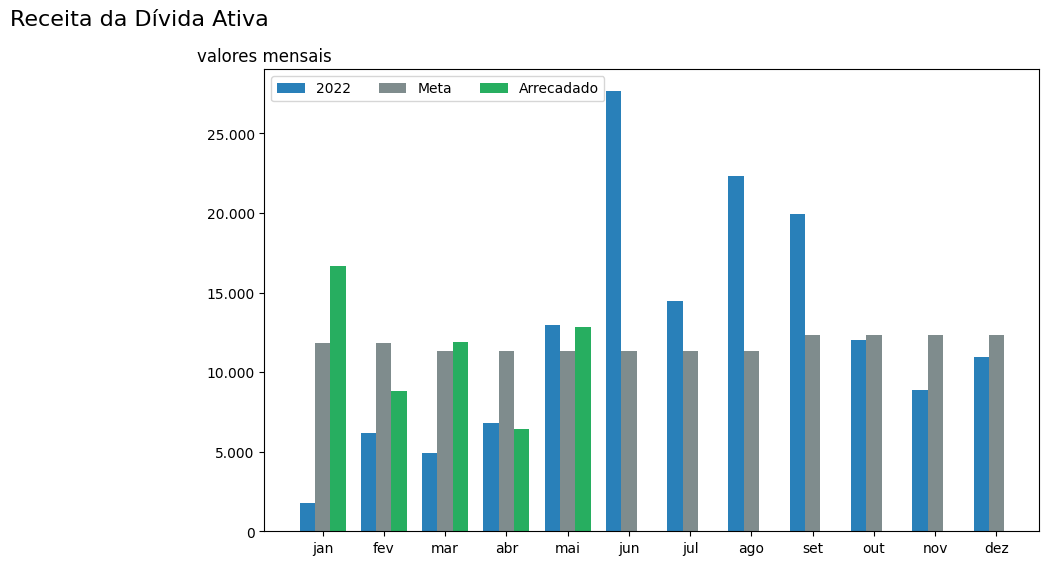

In [23]:
mensal = prepara_df_mensal(receita.copy())
plot_mensal(mensal, nome_receita)

In [24]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores mensais - {dt.year}').hide(axis='index')

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"1.769,14","11.833,31","16.647,96","14.878,82",841%,"4.814,65",41%
fev,"6.147,56","11.833,31","8.843,34","2.695,78",44%,"(2.989,97)",(25%)
mar,"4.908,84","11.333,31","11.886,46","6.977,62",142%,"553,15",5%
abr,"6.799,55","11.333,31","6.401,79","(397,76)",(6%),"(4.931,52)",(44%)
mai,"12.928,36","11.333,31","12.856,92","(71,44)",(1%),"1.523,61",13%
jun,"27.642,44","11.333,31",,,,,
jul,"14.440,18","11.333,31",,,,,
ago,"22.301,79","11.333,31",,,,,
set,"19.928,57","12.333,31",,,,,
out,"11.999,28","12.333,31",,,,,


## Transferências Correntes

In [25]:
nome_receita = 'Transferências Correntes'
sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado,
    SUM(meta_mensal) AS meta
FROM pad."RECEITA"

WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '17%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_atual = sqldf(sql)
#receita_atual

sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado
FROM pad."RECEITA"

WHERE
    controle = {controle_mes_ano_anterior}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '17%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_anterior = sqldf(sql)
#receita_anterior

receita = receita_atual
receita['anterior'] = receita_anterior['arrecadado']
receita['data_base'] = pd.to_datetime(receita['data_base'], format='%Y-%m-%d')
#receita.dtypes

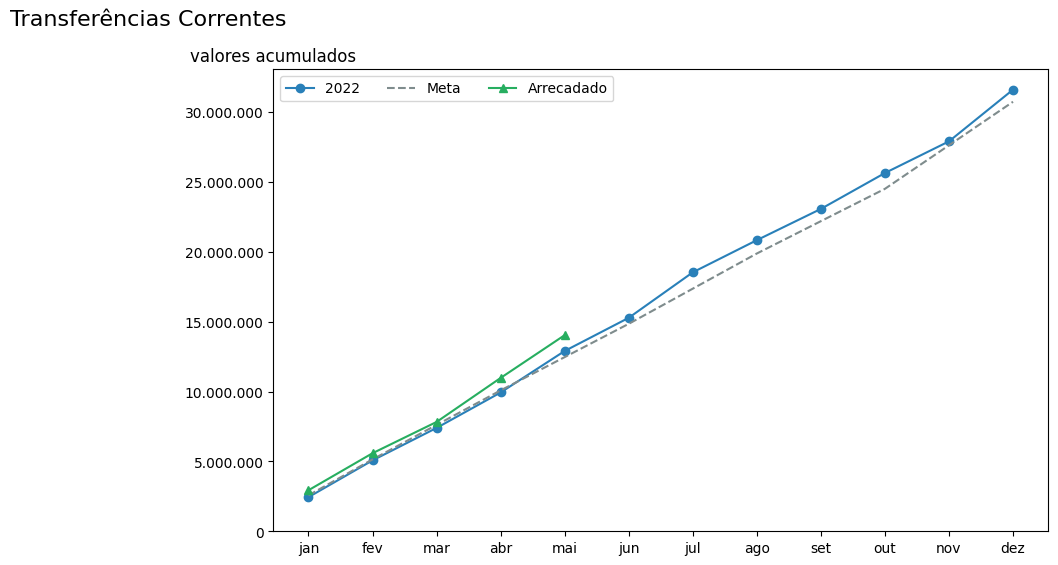

In [26]:
acumulado = prepara_df_acumulado(receita.copy())
plot_acumulado(acumulado, nome_receita)

In [27]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"2.444.286,52","2.572.770,10","2.937.761,56","493.475,04",20%,"364.991,46",14%
fev,"5.074.639,68","5.145.540,20","5.588.278,97","513.639,29",10%,"442.738,77",9%
mar,"7.398.416,56","7.615.504,58","7.827.767,41","429.350,85",6%,"212.262,83",3%
abr,"9.936.293,39","10.085.468,96","10.978.487,18","1.042.193,79",10%,"893.018,22",9%
mai,"12.906.684,36","12.469.027,06","14.041.654,31","1.134.969,95",9%,"1.572.627,25",13%
jun,"15.282.010,49","14.852.585,16",,,,,
jul,"18.538.728,96","17.369.409,26",,,,,
ago,"20.840.901,13","19.886.233,36",,,,,
set,"23.078.375,78","22.201.480,96",,,,,
out,"25.648.942,21","24.516.728,56",,,,,


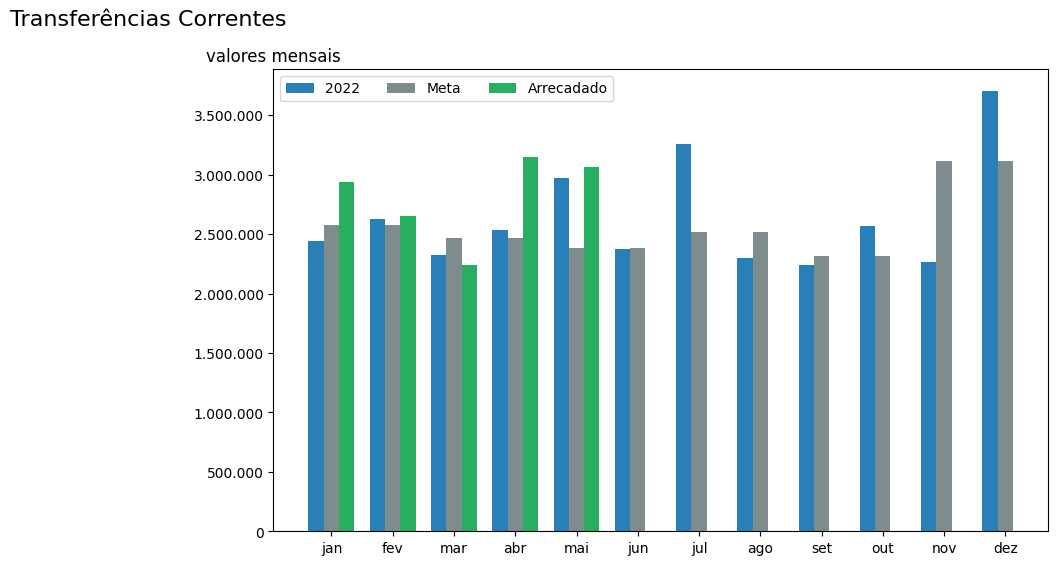

In [28]:
mensal = prepara_df_mensal(receita.copy())
plot_mensal(mensal, nome_receita)

In [29]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores mensais - {dt.year}').hide(axis='index')

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"2.444.286,52","2.572.770,10","2.937.761,56","493.475,04",20%,"364.991,46",14%
fev,"2.630.353,16","2.572.770,10","2.650.517,41","20.164,25",1%,"77.747,31",3%
mar,"2.323.776,88","2.469.964,38","2.239.488,44","(84.288,44)",(4%),"(230.475,94)",(9%)
abr,"2.537.876,83","2.469.964,38","3.150.719,77","612.842,94",24%,"680.755,39",28%
mai,"2.970.390,97","2.383.558,10","3.063.167,13","92.776,16",3%,"679.609,03",29%
jun,"2.375.326,13","2.383.558,10",,,,,
jul,"3.256.718,47","2.516.824,10",,,,,
ago,"2.302.172,17","2.516.824,10",,,,,
set,"2.237.474,65","2.315.247,60",,,,,
out,"2.570.566,43","2.315.247,60",,,,,


### Transferências do Fundeb

Engloba os valores recebidos do Fundeb. Não são considerados os rendimentos financeiros nem os valores deduzidos para o Fundeb.

In [30]:
nome_receita = 'Transferências do Fundeb'
sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado,
    SUM(meta_mensal) AS meta
FROM pad."RECEITA"

WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '17%%'
    AND fonte_recurso IN (540, 541, 542, 543)
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_atual = sqldf(sql)
#receita_atual

sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado
FROM pad."RECEITA"

WHERE
    controle = {controle_mes_ano_anterior}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '17%%'
    AND fonte_recurso IN (540, 541, 542, 543)
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_anterior = sqldf(sql)
#receita_anterior

receita = receita_atual
receita['anterior'] = receita_anterior['arrecadado']
receita['data_base'] = pd.to_datetime(receita['data_base'], format='%Y-%m-%d')
#receita.dtypes

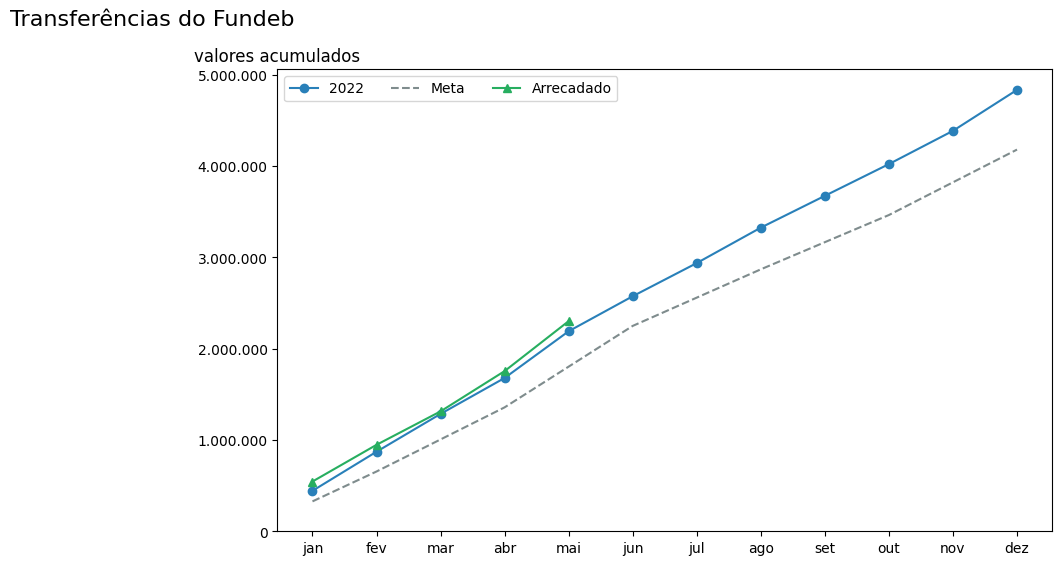

In [31]:
acumulado = prepara_df_acumulado(receita.copy())
plot_acumulado(acumulado, nome_receita)

In [32]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"443.280,96","327.500,00","545.237,54","101.956,58",23%,"217.737,54",66%
fev,"871.836,54","655.000,00","947.410,94","75.574,40",9%,"292.410,94",45%
mar,"1.286.360,20","1.006.500,00","1.314.081,34","27.721,14",2%,"307.581,34",31%
abr,"1.679.888,51","1.358.000,00","1.755.230,08","75.341,57",4%,"397.230,08",29%
mai,"2.191.972,59","1.804.200,00","2.302.747,18","110.774,59",5%,"498.547,18",28%
jun,"2.575.465,97","2.250.400,00",,,,,
jul,"2.938.947,00","2.560.400,00",,,,,
ago,"3.327.078,40","2.870.400,00",,,,,
set,"3.675.845,55","3.167.900,00",,,,,
out,"4.023.549,89","3.465.400,00",,,,,


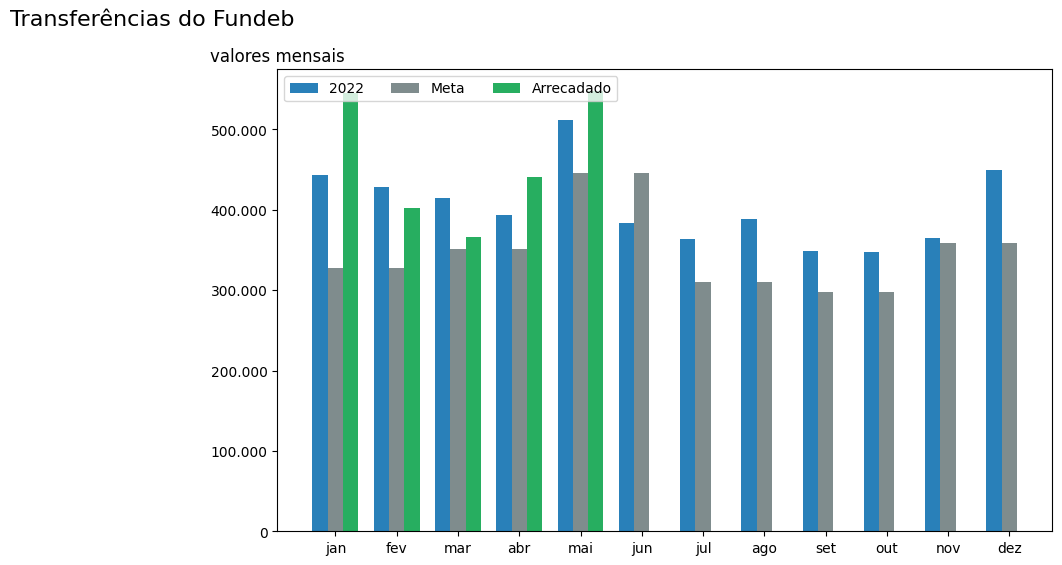

In [33]:
mensal = prepara_df_mensal(receita.copy())
plot_mensal(mensal, nome_receita)

In [34]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores mensais - {dt.year}').hide(axis='index')

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"443.280,96","327.500,00","545.237,54","101.956,58",23%,"217.737,54",66%
fev,"428.555,58","327.500,00","402.173,40","(26.382,18)",(6%),"74.673,40",23%
mar,"414.523,66","351.500,00","366.670,40","(47.853,26)",(12%),"15.170,40",4%
abr,"393.528,31","351.500,00","441.148,74","47.620,43",12%,"89.648,74",26%
mai,"512.084,08","446.200,00","547.517,10","35.433,02",7%,"101.317,10",23%
jun,"383.493,38","446.200,00",,,,,
jul,"363.481,03","310.000,00",,,,,
ago,"388.131,40","310.000,00",,,,,
set,"348.767,15","297.500,00",,,,,
out,"347.704,34","297.500,00",,,,,


### Transferências recebidas da União

Engloba as transferências correntes recebidas da União, inclusive convênios.

In [35]:
nome_receita = 'Transferências recebidas da União'
sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado,
    SUM(meta_mensal) AS meta
FROM pad."RECEITA"

WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '171%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_atual = sqldf(sql)
#receita_atual

sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado
FROM pad."RECEITA"

WHERE
    controle = {controle_mes_ano_anterior}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '171%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_anterior = sqldf(sql)
#receita_anterior

receita = receita_atual
receita['anterior'] = receita_anterior['arrecadado']
receita['data_base'] = pd.to_datetime(receita['data_base'], format='%Y-%m-%d')
#receita.dtypes

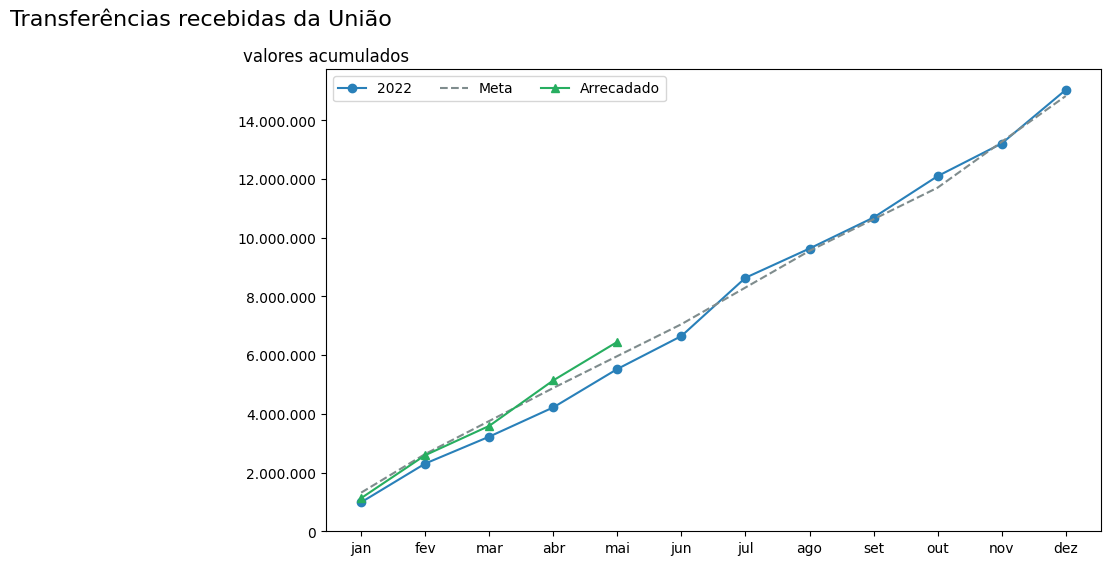

In [36]:
acumulado = prepara_df_acumulado(receita.copy())
plot_acumulado(acumulado, nome_receita)

In [37]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"988.361,22","1.316.573,80","1.129.670,31","141.309,09",14%,"(186.903,49)",(14%)
fev,"2.307.197,66","2.633.147,60","2.591.885,74","284.688,08",12%,"(41.261,86)",(2%)
mar,"3.224.531,14","3.758.132,54","3.591.339,02","366.807,88",11%,"(166.793,52)",(4%)
abr,"4.221.831,05","4.883.117,47","5.141.802,16","919.971,11",22%,"258.684,69",5%
mai,"5.530.055,18","5.969.591,27","6.454.854,66","924.799,48",17%,"485.263,39",8%
jun,"6.652.405,41","7.056.065,07",,,,,
jul,"8.637.776,64","8.305.604,87",,,,,
ago,"9.634.015,05","9.555.144,67",,,,,
set,"10.690.494,31","10.631.607,97",,,,,
out,"12.100.504,67","11.708.071,27",,,,,


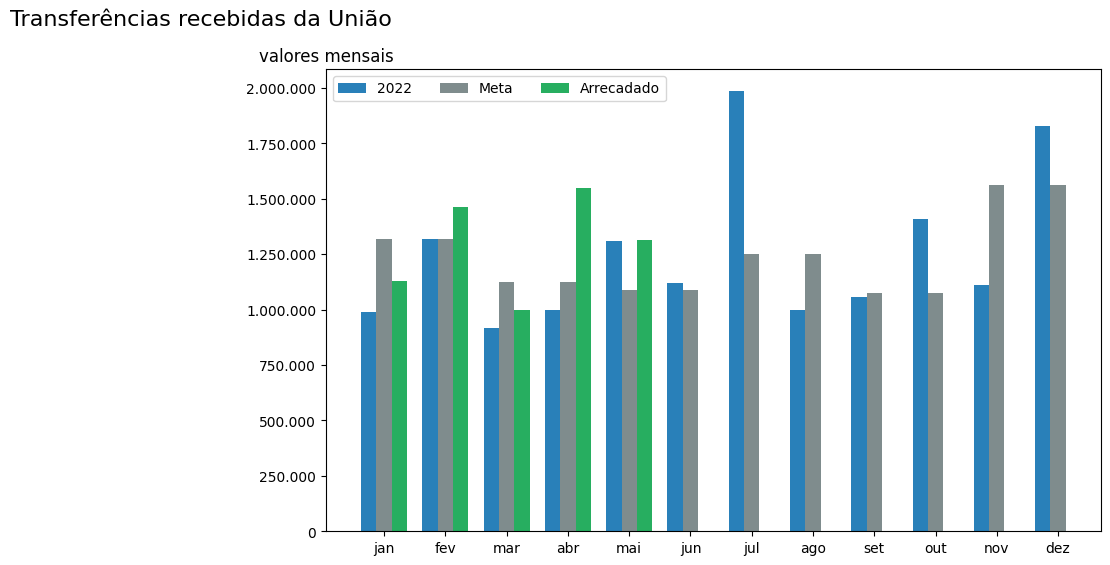

In [38]:
mensal = prepara_df_mensal(receita.copy())
plot_mensal(mensal, nome_receita)

In [39]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores mensais - {dt.year}').hide(axis='index')

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"988.361,22","1.316.573,80","1.129.670,31","141.309,09",14%,"(186.903,49)",(14%)
fev,"1.318.836,44","1.316.573,80","1.462.215,43","143.378,99",11%,"145.641,63",11%
mar,"917.333,48","1.124.984,94","999.453,28","82.119,80",9%,"(125.531,66)",(11%)
abr,"997.299,91","1.124.984,93","1.550.463,14","553.163,23",55%,"425.478,21",38%
mai,"1.308.224,13","1.086.473,80","1.313.052,50","4.828,37",-,"226.578,70",21%
jun,"1.122.350,23","1.086.473,80",,,,,
jul,"1.985.371,23","1.249.539,80",,,,,
ago,"996.238,41","1.249.539,80",,,,,
set,"1.056.479,26","1.076.463,30",,,,,
out,"1.410.010,36","1.076.463,30",,,,,


#### FPM

Engloba as cotas mensais e extras.

In [40]:
nome_receita = 'FPM'
sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado,
    SUM(meta_mensal) AS meta
FROM pad."RECEITA"

WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '171151%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_atual = sqldf(sql)
#receita_atual

sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado
FROM pad."RECEITA"

WHERE
    controle = {controle_mes_ano_anterior}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '1718012%%'
    OR receita_base LIKE '1718013%%'
    OR receita_base LIKE '1718013%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_anterior = sqldf(sql)
#receita_anterior

receita = receita_atual
receita['anterior'] = receita_anterior['arrecadado']
receita['data_base'] = pd.to_datetime(receita['data_base'], format='%Y-%m-%d')
#receita.dtypes

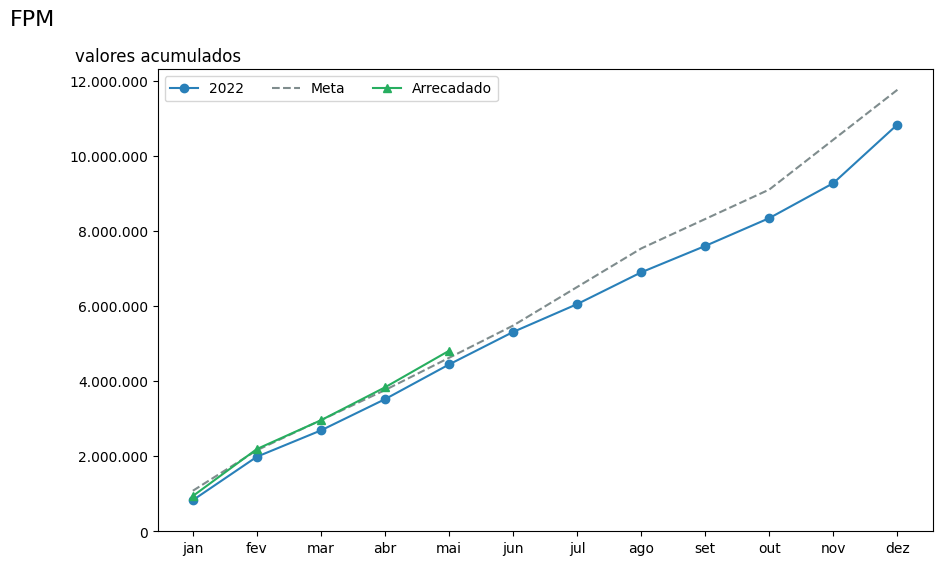

In [41]:
acumulado = prepara_df_acumulado(receita.copy())
plot_acumulado(acumulado, nome_receita)

In [42]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"829.426,58","1.080.000,00","939.271,47","109.844,89",13%,"(140.728,53)",(13%)
fev,"1.987.236,13","2.160.000,00","2.192.932,73","205.696,60",10%,"32.932,73",2%
mar,"2.689.147,28","2.962.000,00","2.959.854,82","270.707,54",10%,"(2.145,18)",-
abr,"3.521.160,53","3.764.000,00","3.836.686,10","315.525,57",9%,"72.686,10",2%
mai,"4.446.692,24","4.623.600,00","4.811.424,85","364.732,61",8%,"187.824,85",4%
jun,"5.312.703,76","5.483.200,00",,,,,
jul,"6.055.419,96","6.511.066,00",,,,,
ago,"6.902.289,26","7.538.932,00",,,,,
set,"7.605.835,88","8.324.121,50",,,,,
out,"8.347.936,04","9.109.311,00",,,,,


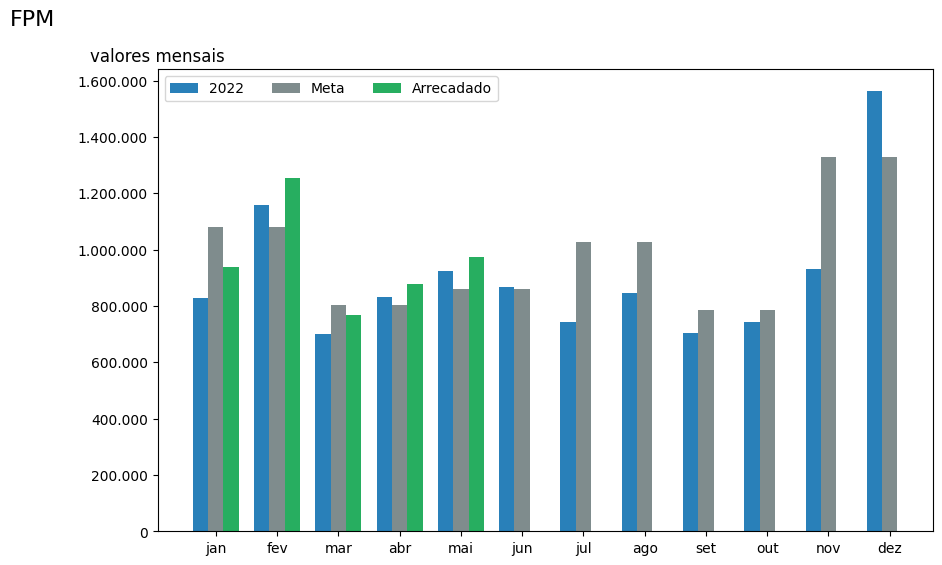

In [43]:
mensal = prepara_df_mensal(receita.copy())
plot_mensal(mensal, nome_receita)

In [44]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores mensais - {dt.year}').hide(axis='index')

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"829.426,58","1.080.000,00","939.271,47","109.844,89",13%,"(140.728,53)",(13%)
fev,"1.157.809,55","1.080.000,00","1.253.661,26","95.851,71",8%,"173.661,26",16%
mar,"701.911,15","802.000,00","766.922,09","65.010,94",9%,"(35.077,91)",(4%)
abr,"832.013,25","802.000,00","876.831,28","44.818,03",5%,"74.831,28",9%
mai,"925.531,71","859.600,00","974.738,75","49.207,04",5%,"115.138,75",13%
jun,"866.011,52","859.600,00",,,,,
jul,"742.716,20","1.027.866,00",,,,,
ago,"846.869,30","1.027.866,00",,,,,
set,"703.546,62","785.189,50",,,,,
out,"742.100,16","785.189,50",,,,,


### Transferências recebidas do Estado

Engloaba as transferências correntes recebidas do Estado, inclusive convênios.

In [45]:
nome_receita = 'Transferências recebidas do Estado'
sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado,
    SUM(meta_mensal) AS meta
FROM pad."RECEITA"

WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '172%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_atual = sqldf(sql)
#receita_atual

sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado
FROM pad."RECEITA"

WHERE
    controle = {controle_mes_ano_anterior}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '172%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_anterior = sqldf(sql)
#receita_anterior

receita = receita_atual
receita['anterior'] = receita_anterior['arrecadado']
receita['data_base'] = pd.to_datetime(receita['data_base'], format='%Y-%m-%d')
#receita.dtypes

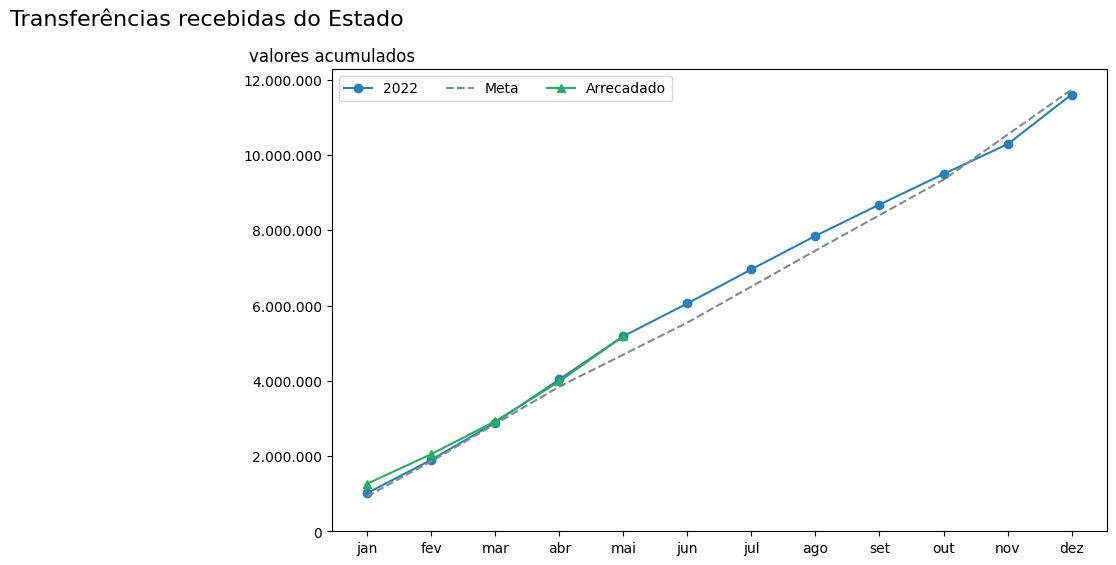

In [46]:
acumulado = prepara_df_acumulado(receita.copy())
plot_acumulado(acumulado, nome_receita)

In [47]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"1.012.644,34","928.696,30","1.262.853,71","250.209,37",25%,"334.157,41",36%
fev,"1.895.605,48","1.857.392,60","2.048.982,29","153.376,81",8%,"191.589,69",10%
mar,"2.887.525,22","2.850.872,04","2.922.347,05","34.821,83",1%,"71.475,01",3%
abr,"4.034.573,83","3.844.351,49","3.981.454,94","(53.118,89)",(1%),"137.103,45",4%
mai,"5.184.656,59","4.695.235,79","5.184.052,47","(604,12)",-,"488.816,68",10%
jun,"6.054.139,11","5.546.120,09",,,,,
jul,"6.962.005,32","6.503.404,39",,,,,
ago,"7.850.780,88","7.460.688,69",,,,,
set,"8.683.009,12","8.401.972,99",,,,,
out,"9.495.860,85","9.343.257,29",,,,,


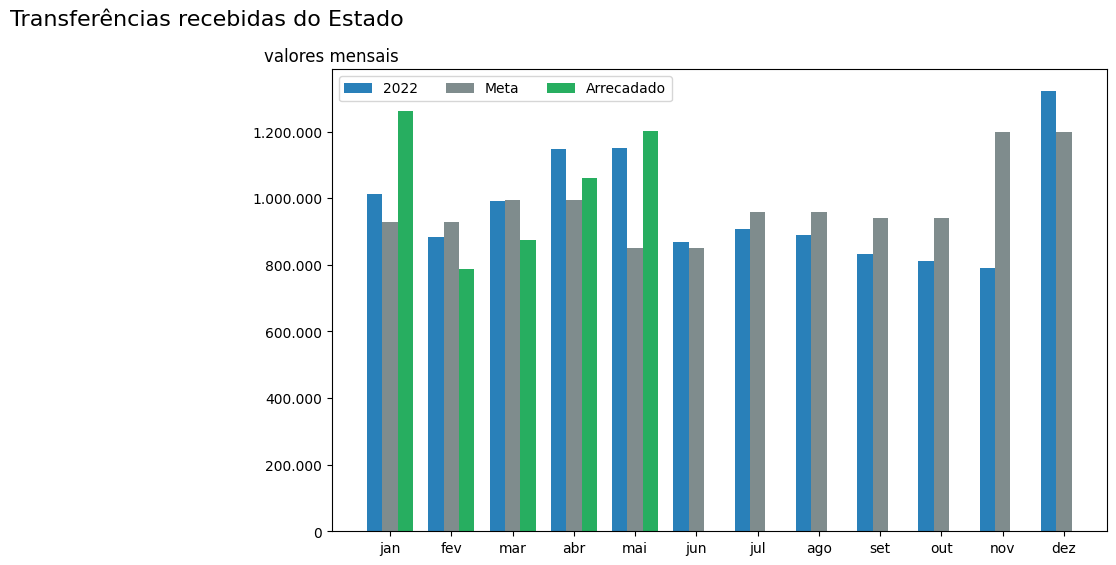

In [48]:
mensal = prepara_df_mensal(receita.copy())
plot_mensal(mensal, nome_receita)

In [49]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores mensais - {dt.year}').hide(axis='index')

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"1.012.644,34","928.696,30","1.262.853,71","250.209,37",25%,"334.157,41",36%
fev,"882.961,14","928.696,30","786.128,58","(96.832,56)",(11%),"(142.567,72)",(15%)
mar,"991.919,74","993.479,44","873.364,76","(118.554,98)",(12%),"(120.114,68)",(12%)
abr,"1.147.048,61","993.479,45","1.059.107,89","(87.940,72)",(8%),"65.628,44",7%
mai,"1.150.082,76","850.884,30","1.202.597,53","52.514,77",5%,"351.713,23",41%
jun,"869.482,52","850.884,30",,,,,
jul,"907.866,21","957.284,30",,,,,
ago,"888.775,56","957.284,30",,,,,
set,"832.228,24","941.284,30",,,,,
out,"812.851,73","941.284,30",,,,,


#### ICMS

In [50]:
nome_receita = 'ICMS'
sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado,
    SUM(meta_mensal) AS meta
FROM pad."RECEITA"

WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '172150%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_atual = sqldf(sql)
#receita_atual

sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado
FROM pad."RECEITA"

WHERE
    controle = {controle_mes_ano_anterior}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '1728011%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_anterior = sqldf(sql)
#receita_anterior

receita = receita_atual
receita['anterior'] = receita_anterior['arrecadado']
receita['data_base'] = pd.to_datetime(receita['data_base'], format='%Y-%m-%d')
#receita.dtypes

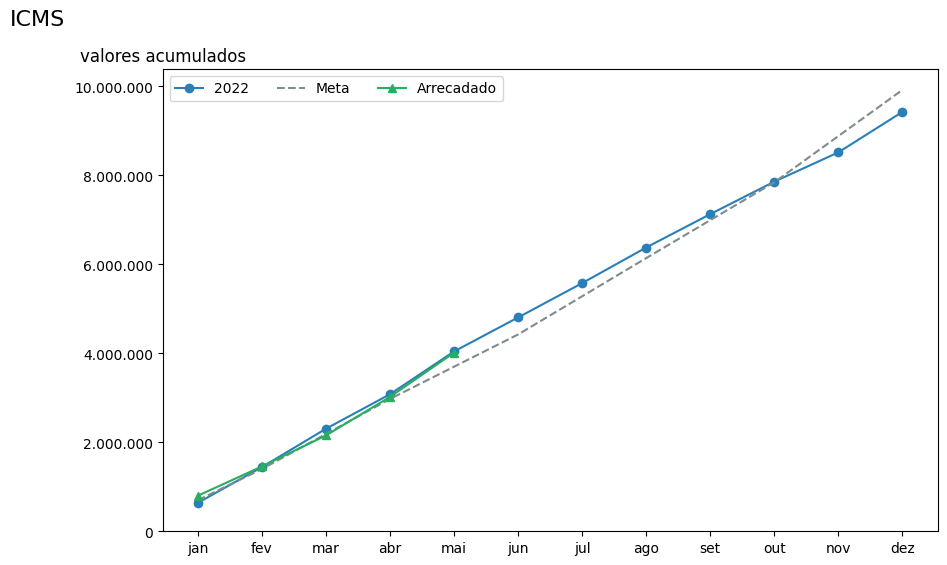

In [51]:
acumulado = prepara_df_acumulado(receita.copy())
plot_acumulado(acumulado, nome_receita)

In [52]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"639.349,64","699.600,00","799.543,36","160.193,72",25%,"99.943,36",14%
fev,"1.442.717,56","1.399.200,00","1.457.067,23","14.349,67",1%,"57.867,23",4%
mar,"2.304.843,34","2.186.800,00","2.154.256,46","(150.586,88)",(7%),"(32.543,54)",(1%)
abr,"3.080.150,34","2.974.400,00","3.020.392,03","(59.758,31)",(2%),"45.992,03",2%
mai,"4.041.774,09","3.699.200,00","4.014.897,05","(26.877,04)",(1%),"315.697,05",9%
jun,"4.806.188,36","4.424.000,00",,,,,
jul,"5.577.392,00","5.282.000,00",,,,,
ago,"6.378.112,56","6.140.000,00",,,,,
set,"7.128.373,85","6.992.000,00",,,,,
out,"7.858.515,51","7.844.000,00",,,,,


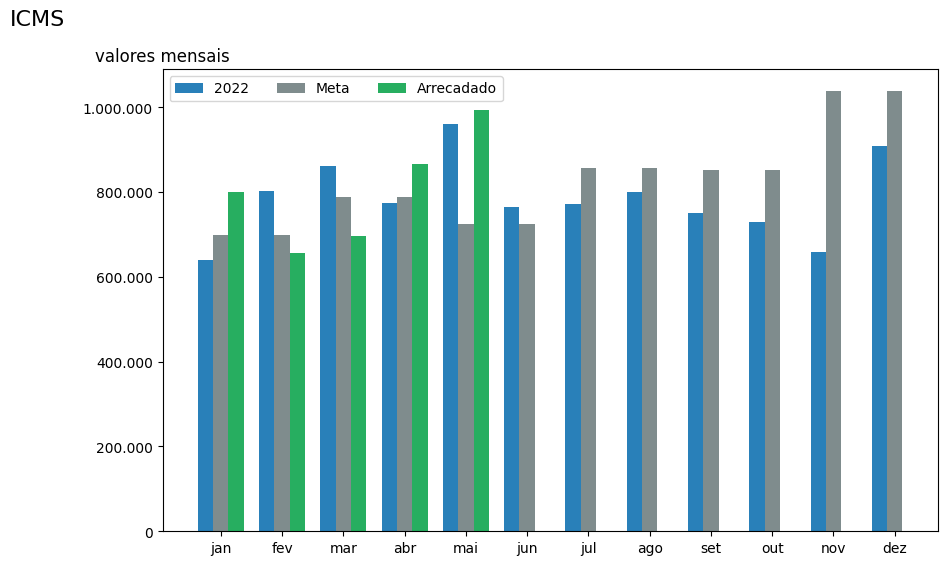

In [53]:
mensal = prepara_df_mensal(receita.copy())
plot_mensal(mensal, nome_receita)

In [54]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores mensais - {dt.year}').hide(axis='index')

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"639.349,64","699.600,00","799.543,36","160.193,72",25%,"99.943,36",14%
fev,"803.367,92","699.600,00","657.523,87","(145.844,05)",(18%),"(42.076,13)",(6%)
mar,"862.125,78","787.600,00","697.189,23","(164.936,55)",(19%),"(90.410,77)",(11%)
abr,"775.307,00","787.600,00","866.135,57","90.828,57",12%,"78.535,57",10%
mai,"961.623,75","724.800,00","994.505,02","32.881,27",3%,"269.705,02",37%
jun,"764.414,27","724.800,00",,,,,
jul,"771.203,64","858.000,00",,,,,
ago,"800.720,56","858.000,00",,,,,
set,"750.261,29","852.000,00",,,,,
out,"730.141,66","852.000,00",,,,,


### Transferências para a Saúde

Considera as transferências correntes recebidas da União e do Estado para a área da Saúde.

In [55]:
nome_receita = 'Transferências para a Saúde'
sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado,
    SUM(meta_mensal) AS meta
FROM pad."RECEITA"

WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '17%%'
    AND fonte_recurso BETWEEN 600 AND 659
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_atual = sqldf(sql)
#receita_atual

sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado
FROM pad."RECEITA"

WHERE
    controle = {controle_mes_ano_anterior}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '171803%%'
    OR receita_base LIKE '171804%%'
    OR receita_base LIKE '1718101%%'
    OR receita_base LIKE '172803%%'
    OR receita_base LIKE '1728101%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_anterior = sqldf(sql)
#receita_anterior

receita = receita_atual
receita['anterior'] = receita_anterior['arrecadado']
receita['data_base'] = pd.to_datetime(receita['data_base'], format='%Y-%m-%d')
#receita.dtypes

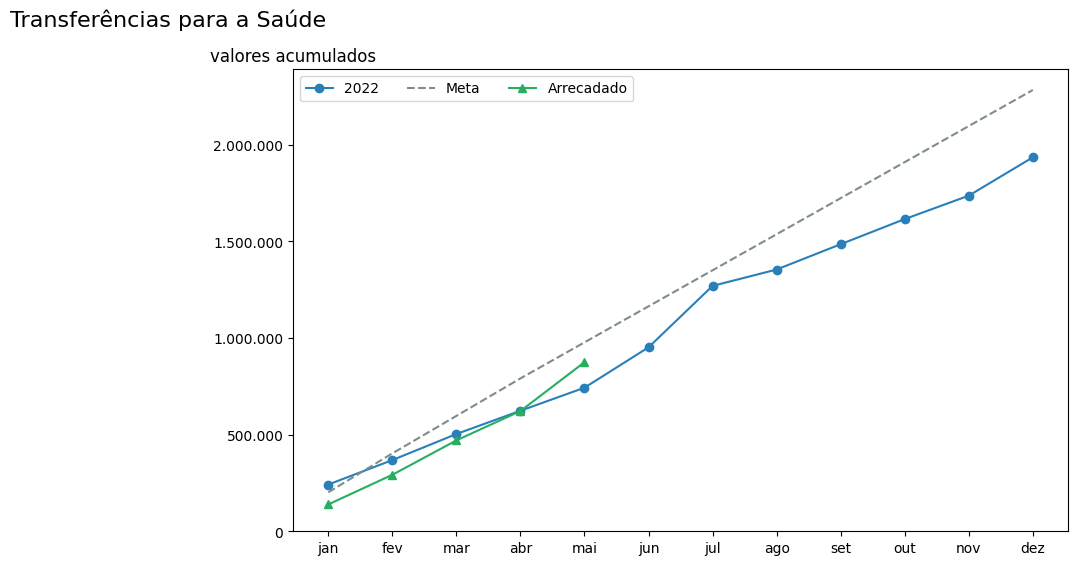

In [56]:
acumulado = prepara_df_acumulado(receita.copy())
plot_acumulado(acumulado, nome_receita)

In [57]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"241.772,18","201.499,95","138.895,58","(102.876,60)",(43%),"(62.604,37)",(31%)
fev,"368.257,64","402.999,90","292.190,82","(76.066,82)",(21%),"(110.809,08)",(27%)
mar,"503.161,34","596.894,99","470.176,03","(32.985,31)",(7%),"(126.718,96)",(21%)
abr,"623.535,08","790.790,09","622.075,44","(1.459,64)",-,"(168.714,65)",(21%)
mai,"742.754,20","977.290,04","874.717,49","131.963,29",18%,"(102.572,55)",(10%)
jun,"951.580,07","1.163.789,99",,,,,
jul,"1.269.431,58","1.350.289,94",,,,,
ago,"1.354.106,03","1.536.789,89",,,,,
set,"1.485.120,68","1.723.289,84",,,,,
out,"1.615.096,65","1.909.789,79",,,,,


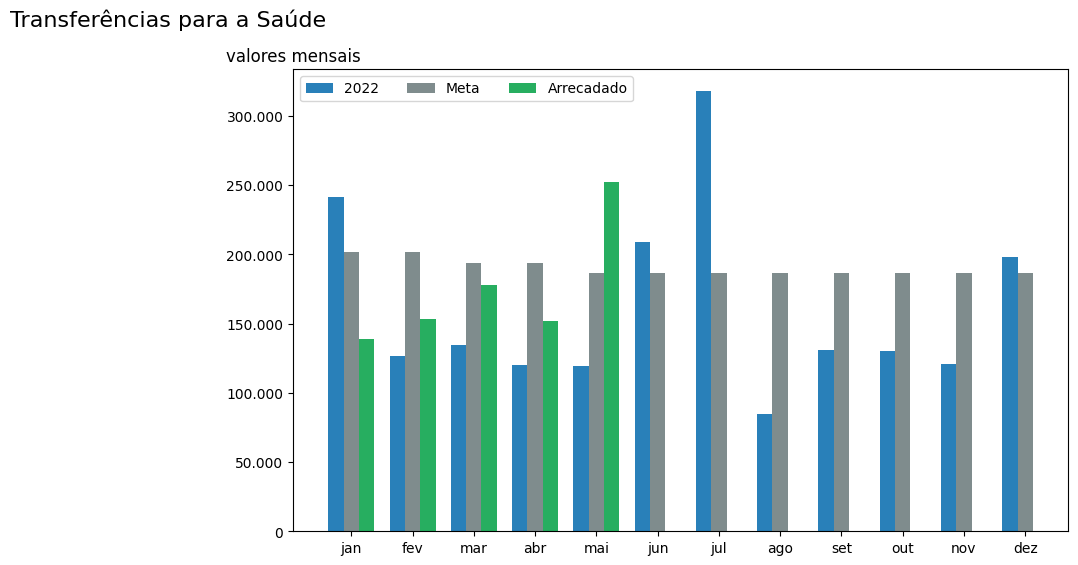

In [58]:
mensal = prepara_df_mensal(receita.copy())
plot_mensal(mensal, nome_receita)

In [59]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores mensais - {dt.year}').hide(axis='index')

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"241.772,18","201.499,95","138.895,58","(102.876,60)",(43%),"(62.604,37)",(31%)
fev,"126.485,46","201.499,95","153.295,24","26.809,78",21%,"(48.204,71)",(24%)
mar,"134.903,70","193.895,09","177.985,21","43.081,51",32%,"(15.909,88)",(8%)
abr,"120.373,74","193.895,10","151.899,41","31.525,67",26%,"(41.995,69)",(22%)
mai,"119.219,12","186.499,95","252.642,05","133.422,93",112%,"66.142,10",35%
jun,"208.825,87","186.499,95",,,,,
jul,"317.851,51","186.499,95",,,,,
ago,"84.674,45","186.499,95",,,,,
set,"131.014,65","186.499,95",,,,,
out,"129.975,97","186.499,95",,,,,


### Transferências para a Educação

Considera as transferências correntes recebidas da União e do Estado para a área da Educação (exceto o Fundeb).

In [60]:
nome_receita = 'Transferências para a Educação'
sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado,
    SUM(meta_mensal) AS meta
FROM pad."RECEITA"

WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '1714%%'
    OR receita_base LIKE '171751%%'
    OR receita_base LIKE '172451%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_atual = sqldf(sql)
#receita_atual

sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado
FROM pad."RECEITA"

WHERE
    controle = {controle_mes_ano_anterior}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '17%%'
    AND fonte_recurso BETWEEN 550 AND 599
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_anterior = sqldf(sql)
#receita_anterior

receita = receita_atual
receita['anterior'] = receita_anterior['arrecadado']
receita['data_base'] = pd.to_datetime(receita['data_base'], format='%Y-%m-%d')
#receita.dtypes

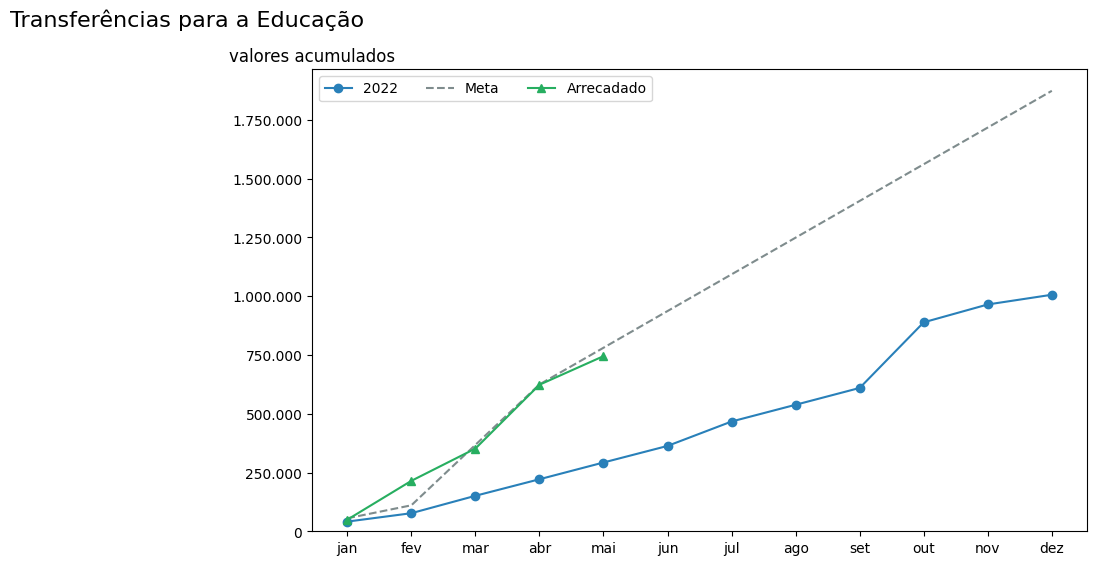

In [61]:
acumulado = prepara_df_acumulado(receita.copy())
plot_acumulado(acumulado, nome_receita)

In [62]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"41.146,49","55.250,00","49.297,36","8.150,87",20%,"(5.952,64)",(11%)
fev,"76.888,13","110.500,00","214.589,43","137.701,30",179%,"104.089,43",94%
mar,"150.956,29","367.558,99","351.870,14","200.913,85",133%,"(15.688,85)",(4%)
abr,"221.349,77","624.617,97","623.367,38","402.017,61",182%,"(1.250,59)",-
mai,"292.594,41","780.767,97","745.032,13","452.437,72",155%,"(35.735,84)",(5%)
jun,"363.112,00","936.917,97",,,,,
jul,"466.991,60","1.093.067,97",,,,,
ago,"538.224,37","1.249.217,97",,,,,
set,"609.800,22","1.405.367,97",,,,,
out,"888.977,31","1.561.517,97",,,,,


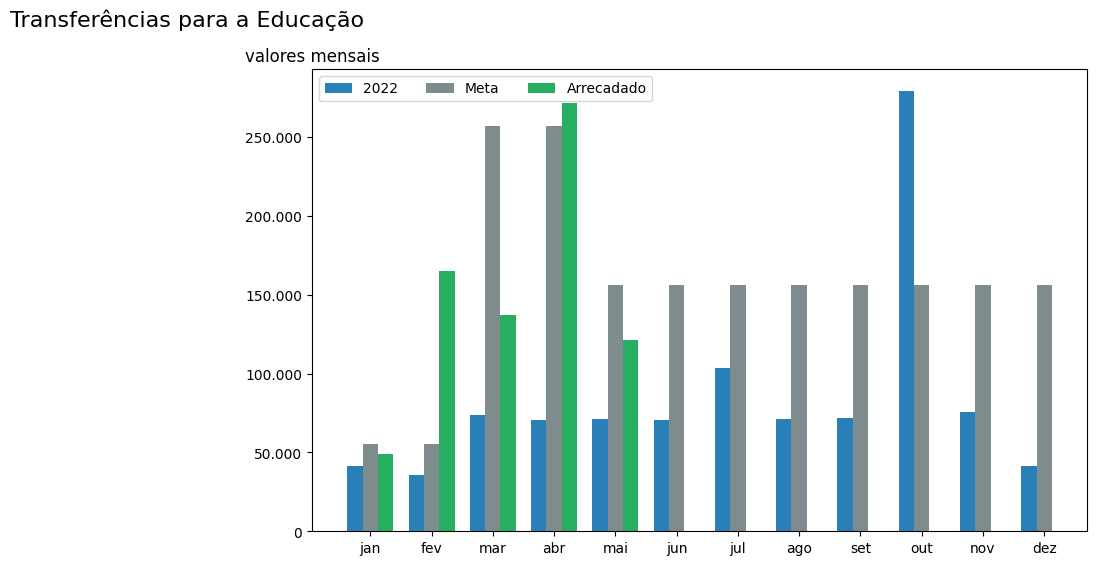

In [63]:
mensal = prepara_df_mensal(receita.copy())
plot_mensal(mensal, nome_receita)

In [64]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores mensais - {dt.year}').hide(axis='index')

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"41.146,49","55.250,00","49.297,36","8.150,87",20%,"(5.952,64)",(11%)
fev,"35.741,64","55.250,00","165.292,07","129.550,43",362%,"110.042,07",199%
mar,"74.068,16","257.058,99","137.280,71","63.212,55",85%,"(119.778,28)",(47%)
abr,"70.393,48","257.058,98","271.497,24","201.103,76",286%,"14.438,26",6%
mai,"71.244,64","156.150,00","121.664,75","50.420,11",71%,"(34.485,25)",(22%)
jun,"70.517,59","156.150,00",,,,,
jul,"103.879,60","156.150,00",,,,,
ago,"71.232,77","156.150,00",,,,,
set,"71.575,85","156.150,00",,,,,
out,"279.177,09","156.150,00",,,,,


### Transferências para a Assistência Social

Considera as transferências correntes recebidas da União e do Estado para a área da Assistência Social.

In [65]:
nome_receita = 'Transferências para a Assistência Social'
sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado,
    SUM(meta_mensal) AS meta
FROM pad."RECEITA"

WHERE
    controle = {controle_mes}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '17%%'
    AND fonte_recurso BETWEEN 660 AND 669
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_atual = sqldf(sql)
#receita_atual

sql = f'''
SELECT
    data_base,
    SUM(receita_realizada) AS arrecadado
FROM pad."RECEITA"

WHERE
    controle = {controle_mes_ano_anterior}
    AND entidade LIKE 'pm'
    AND classe_receita NOT LIKE 'intra'
    AND receita_base LIKE '1718103%%'
    OR receita_base LIKE '171812%%'
    OR receita_base LIKE '172807%%'
    OR receita_base LIKE '1728109107%%'
GROUP BY
    data_base
ORDER BY
    data_base ASC
'''
#print(sql)
receita_anterior = sqldf(sql)
#receita_anterior

receita = receita_atual
receita['anterior'] = receita_anterior['arrecadado']
receita['data_base'] = pd.to_datetime(receita['data_base'], format='%Y-%m-%d')
#receita.dtypes

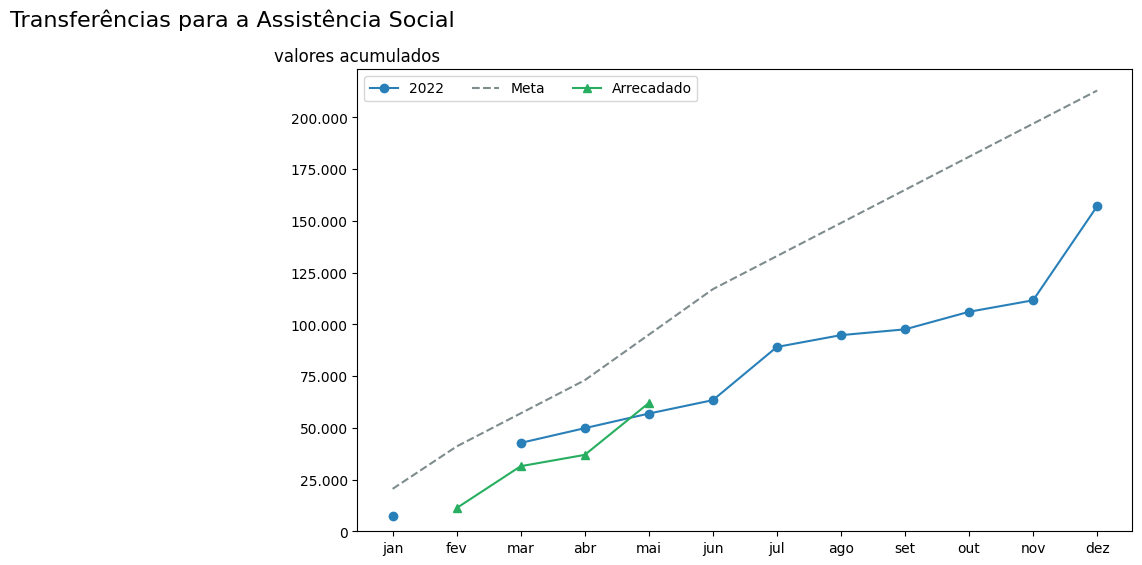

In [66]:
acumulado = prepara_df_acumulado(receita.copy())
plot_acumulado(acumulado, nome_receita)

In [67]:
df = df_table(acumulado.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores acumulados - {dt.year}').hide(axis='index')
#df

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"7.395,07","20.500,00",,,,,
fev,,"41.000,00","11.219,69",,,"(29.780,31)",(73%)
mar,"42.715,43","57.000,00","31.455,90","(11.259,53)",(26%),"(25.544,10)",(45%)
abr,"49.831,74","73.000,00","36.925,10","(12.906,64)",(26%),"(36.074,90)",(49%)
mai,"56.890,15","95.000,00","61.977,37","5.087,22",9%,"(33.022,63)",(35%)
jun,"63.376,35","117.000,00",,,,,
jul,"89.082,65","133.000,00",,,,,
ago,"94.794,38","149.000,00",,,,,
set,"97.594,38","165.000,00",,,,,
out,"106.083,35","181.000,00",,,,,


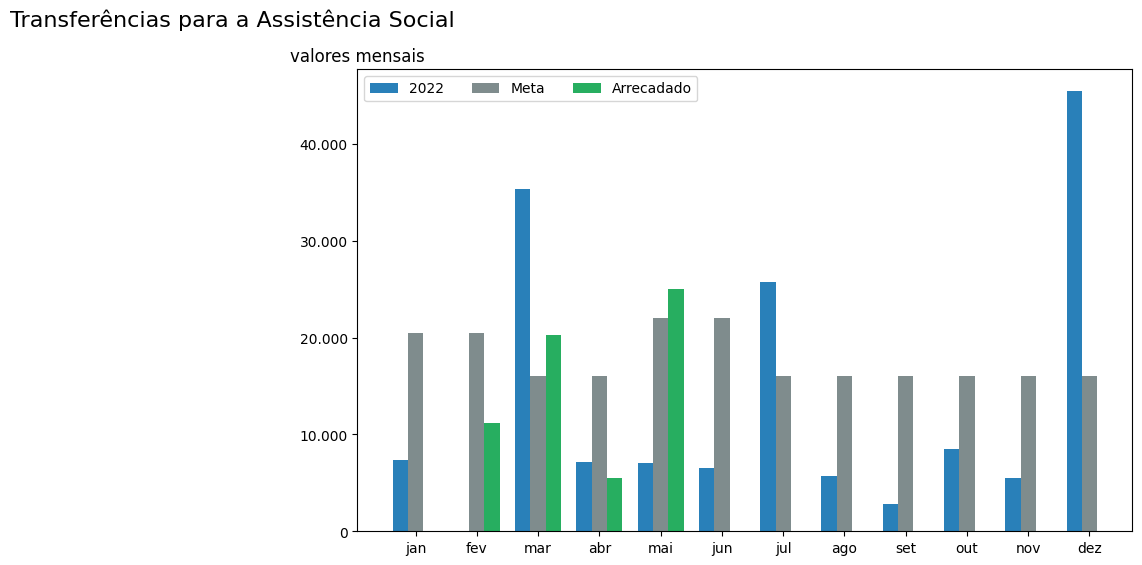

In [68]:
mensal = prepara_df_mensal(receita.copy())
plot_mensal(mensal, nome_receita)

In [69]:
df = df_table(mensal.copy(), spec, fmt)
df.style.set_caption(f'{nome_receita} - valores mensais - {dt.year}').hide(axis='index')

Mês,2022,Meta,2023,2023 - 2022,2023 / 2022,2023 - Meta,2023 / Meta
jan,"7.395,07","20.500,00",,,,,
fev,,"20.500,00","11.219,69",,,"(9.280,31)",(45%)
mar,"35.320,36","16.000,00","20.236,21","(15.084,15)",(43%),"4.236,21",26%
abr,"7.116,31","16.000,00","5.469,20","(1.647,11)",(23%),"(10.530,80)",(66%)
mai,"7.058,41","22.000,00","25.052,27","17.993,86",255%,"3.052,27",14%
jun,"6.486,20","22.000,00",,,,,
jul,"25.706,30","16.000,00",,,,,
ago,"5.711,73","16.000,00",,,,,
set,"2.800,00","16.000,00",,,,,
out,"8.488,97","16.000,00",,,,,
